In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn import tree
import concurrent.futures as cf
import os
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
file = "ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(file)

'''77% of the data was generated synthetically using the Weka tool and the SMOTE filter, 23% of the data was 
collected directly from users through a web platform. According to Data Brief'''
# Round age, and Weight to integer; Round Height to 2 decimal places; As for other float64-type varialbes, they should be integer
integer = ["Age", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
df[integer] = df[integer].apply(np.int64)
df = df.round({"Height": 2})


# convert categorical variables
for column in df.columns:
    if df[column].dtypes == "object":
        df[column] = pd.factorize(df[column])[0]
        
# define x and y
x = df[df.columns[0:16]]; y = df[df.columns[16]]

# split the data into training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 1)

times = list(np.linspace(100, 1414, num=10)) # create equal spaced sample size
times = [int(x) for x in times] # convert times to integer
print(times)

y_test = np.array(list(y_test))

[100, 246, 392, 538, 684, 830, 976, 1122, 1268, 1414]


In [ ]:
# the decision tree classifier function
def f(n):
    X = x_train.sample(n=n,replace=True) # sample from training dataset
    Y = y_train.loc[list(X.index)] #get corresponding Y
    
    # fit the decision tree
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, Y) # fit the decision tree with the sample drawn
    
    # predict the obesity level with the decision tree
    y_predict = clf.predict(x_test)
    
    return (y_predict)

In [73]:
# decision tree (without bagging/bootstrap)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

print('The accuracy rate of decision tree is ', accuracy_score(y_test, y_predict))

The accuracy rate of decision tree is  0.9340028694404591


In [ ]:
ac = []; ti = [] # empty list to sotre accuracy score, and time taken

# multi-processing function
def mult(n,m):
    #n is how large each sample is, m is how many samples are taken
    inputs = [n]*m

    if __name__ == "__main__":
        #uses current.futures module instead of multiprocessing
        with cf.ProcessPoolExecutor() as ex:
            #timing
            start = time.perf_counter()

            #uses map to map the function to the inputs and put into results list
            results = ex.map(f, inputs)
            
            #predicting the class
            pred = np.rint((np.mean([x for x in results], axis = 0)))

            #printing accuracy
            accu = accuracy_score(list(y_test),pred)

            finish = time.perf_counter()

            #time taken
            t = finish - start
            
            ac.append(accu)
            ti.append(t)


In [ ]:
# create a dataframe the store the result
df_time = pd.DataFrame(columns = ['sample size', 'time taken (parallel)', 'accuracy (parallel)'])
df_time['sample size'] = times
# df_time

for x in times:
  mult(x, 1000)

df_time['time taken (parallel)'] = ti
df_time['accuracy (parallel)'] = ac

df_time


,sample size,time taken (parallel),accuracy (parallel)
0,100,2.418997,0.705882
1,246,2.737330,0.862267
2,392,3.002920,0.879484
3,538,3.392259,0.886657
4,684,3.572717,0.898135
5,830,3.865699,0.903874
6,976,4.168618,0.922525
7,1122,4.535631,0.926829
8,1268,4.575667,0.931133
9,1414,5.066876,0.938307


In [ ]:
# for non-parallel computing
t2 = []; ac2 = []

for x in times: #n in parallel computing function
    start = time.perf_counter()
    q = []
    for y in range(1000): #m in parallel computing function   
        t=f(x)
        q.append(t)
    pred = np.rint((np.mean(q, axis = 0)))
    finish = time.perf_counter()
    
    t2.append(finish - start)
    ac2.append(accuracy_score(list(y_test),pred))

df_time['time taken (non-parallel)'] = t2
df_time['accuracy (non-parallel)'] = ac2


In [ ]:
df_time

,sample size,time taken (parallel),accuracy (parallel),time taken (non-parallel),accuracy (non-parallel)
0,100,2.418997,0.705882,2.562794,0.705882
1,246,2.737330,0.862267,2.857053,0.857963
2,392,3.002920,0.879484,3.330296,0.873745
3,538,3.392259,0.886657,3.619281,0.886657
4,684,3.572717,0.898135,3.978163,0.895265
5,830,3.865699,0.903874,4.358633,0.906743
6,976,4.168618,0.922525,4.783588,0.919656
7,1122,4.535631,0.926829,5.115729,0.923960
8,1268,4.575667,0.931133,5.433657,0.925395
9,1414,5.066876,0.938307,5.660789,0.935438


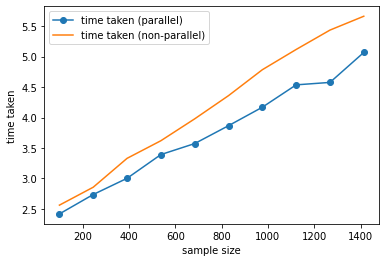

In [ ]:
# visualization of time taken for the whole process
plt.plot('sample size', 'time taken (parallel)', data=df_time, marker = 'o')
plt.plot('sample size', 'time taken (non-parallel)', data=df_time, marker = '')

plt.legend()
plt.xlabel('sample size'); plt.ylabel('time taken')

plt.show()

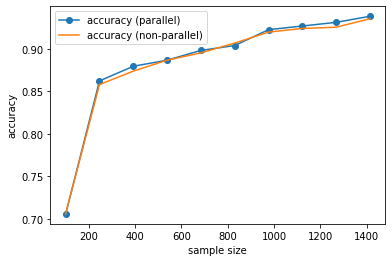

In [ ]:
plt.plot('sample size', 'accuracy (parallel)', data=df_time, marker = 'o')
plt.plot('sample size', 'accuracy (non-parallel)', data=df_time, marker = '')

plt.legend()
plt.xlabel('sample size'); plt.ylabel('accuracy')

plt.show()

The accuracy rates of both parallel computing and non-parallel computing increase with bootstrap sample size, and reach the maximum when n=1414, i.e. the size of the training dataset. Even though the maximum accuracy rate is achieved when n = 1414, it is not significantly different from the accuracy rate of the decision tree without bootstrap. Parallel computing takes less time than non-parallel computing with the same bootstrap sample size.